In [1]:
import pandas as pd
import numpy as np

from medangel.data import preprocessing
from medangel.models import model_builder
from medangel.features import feature_creation

from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import matthews_corrcoef

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.transformers import FeatureSelector

from lightgbm import LGBMClassifier

import re

import time

from tqdm import tqdm

C:\Python\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
features,y = preprocessing.load_feature_data()


classifier__num_leaves = 80
classifier__n_estimators = 250
classifier__max_depth = 7
classifier__boosting_type = 'goss'
augmenter__fdr_level = 0.03


lgbm = Pipeline([
    ('sampler',RandomUnderSampler(random_state=42)),
    ('augmenter',FeatureSelector(fdr_level=augmenter__fdr_level,n_jobs=5)),
    ('classifier',LGBMClassifier(random_state=42,n_jobs=5,device_type = 'gpu',max_bin = 64,num_leaves=classifier__num_leaves,
    n_estimators=classifier__n_estimators,max_depth=classifier__max_depth,boosting_type=classifier__boosting_type)),
])



y_temp = y.loc[y.index.isin(features.index)]
features = features.loc[y_temp.index]
x_array = np.array(features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)))
y_array = np.array(y_temp["label_shifted"])
# y_temp = y.loc[y.index.isin(features.index)]
# features = features.loc[y_temp.index]
# x_array = features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
# y_array = y_temp["label_shifted"]

In [3]:
lgbm.fit(x_array,y_array)

Pipeline(steps=[('sampler', RandomUnderSampler(random_state=42)),
                ('augmenter', FeatureSelector(fdr_level=0.03, n_jobs=5)),
                ('classifier',
                 LGBMClassifier(boosting_type='goss', device_type='gpu',
                                max_bin=64, max_depth=7, n_estimators=250,
                                n_jobs=5, num_leaves=80, random_state=42))])

In [4]:
lgbm.named_steps

{'sampler': RandomUnderSampler(random_state=42),
 'augmenter': FeatureSelector(fdr_level=0.03, n_jobs=5),
 'classifier': LGBMClassifier(boosting_type='goss', device_type='gpu', max_bin=64, max_depth=7,
                n_estimators=250, n_jobs=5, num_leaves=80, random_state=42)}

In [5]:
lgbm.named_steps["augmenter"].__dict__

{'relevant_features': [4,
  117,
  116,
  115,
  114,
  146,
  477,
  478,
  474,
  148,
  149,
  150,
  479,
  473,
  152,
  153,
  154,
  471,
  156,
  157,
  158,
  470,
  118,
  160,
  119,
  121,
  142,
  141,
  140,
  145,
  138,
  137,
  136,
  135,
  134,
  133,
  132,
  131,
  130,
  129,
  128,
  127,
  126,
  125,
  124,
  123,
  122,
  120,
  475,
  161,
  165,
  164,
  30,
  29,
  166,
  168,
  169,
  33,
  170,
  235,
  17,
  10,
  9,
  337,
  5,
  454,
  34,
  144,
  85,
  90,
  89,
  88,
  39,
  40,
  87,
  41,
  86,
  35,
  469,
  162,
  83,
  84,
  440,
  500,
  12,
  14,
  499,
  497,
  494,
  493,
  495,
  496,
  498,
  456,
  13,
  439,
  356,
  352,
  354,
  194,
  355,
  357,
  31,
  362,
  379,
  361,
  341,
  353,
  364,
  365,
  358,
  363,
  366,
  359,
  344,
  345,
  342,
  360,
  210,
  367,
  368,
  340,
  339,
  190,
  343,
  28,
  351,
  480,
  43,
  378,
  380,
  377,
  384,
  222,
  338,
  370,
  192,
  171,
  382,
  374,
  535,
  346,
  372,
  383,
 

In [6]:
len(lgbm.named_steps["augmenter"].p_values)

541

In [7]:
len(lgbm.named_steps["augmenter"].relevant_features)

528

In [8]:
len(lgbm.named_steps["augmenter"].features)

541

In [9]:
lgbm.named_steps["classifier"].__dict__.keys()

dict_keys(['boosting_type', 'objective', 'num_leaves', 'max_depth', 'learning_rate', 'n_estimators', 'subsample_for_bin', 'min_split_gain', 'min_child_weight', 'min_child_samples', 'subsample', 'subsample_freq', 'colsample_bytree', 'reg_alpha', 'reg_lambda', 'random_state', 'n_jobs', 'silent', 'importance_type', '_Booster', '_evals_result', '_best_score', '_best_iteration', '_other_params', '_objective', 'class_weight', '_class_weight', '_class_map', '_n_features', '_n_features_in', '_classes', '_n_classes', 'device_type', 'max_bin', '_le', '_fobj', 'fitted_'])

In [10]:
lgbm.named_steps["classifier"].__class__

lightgbm.sklearn.LGBMClassifier

In [11]:
import lightgbm

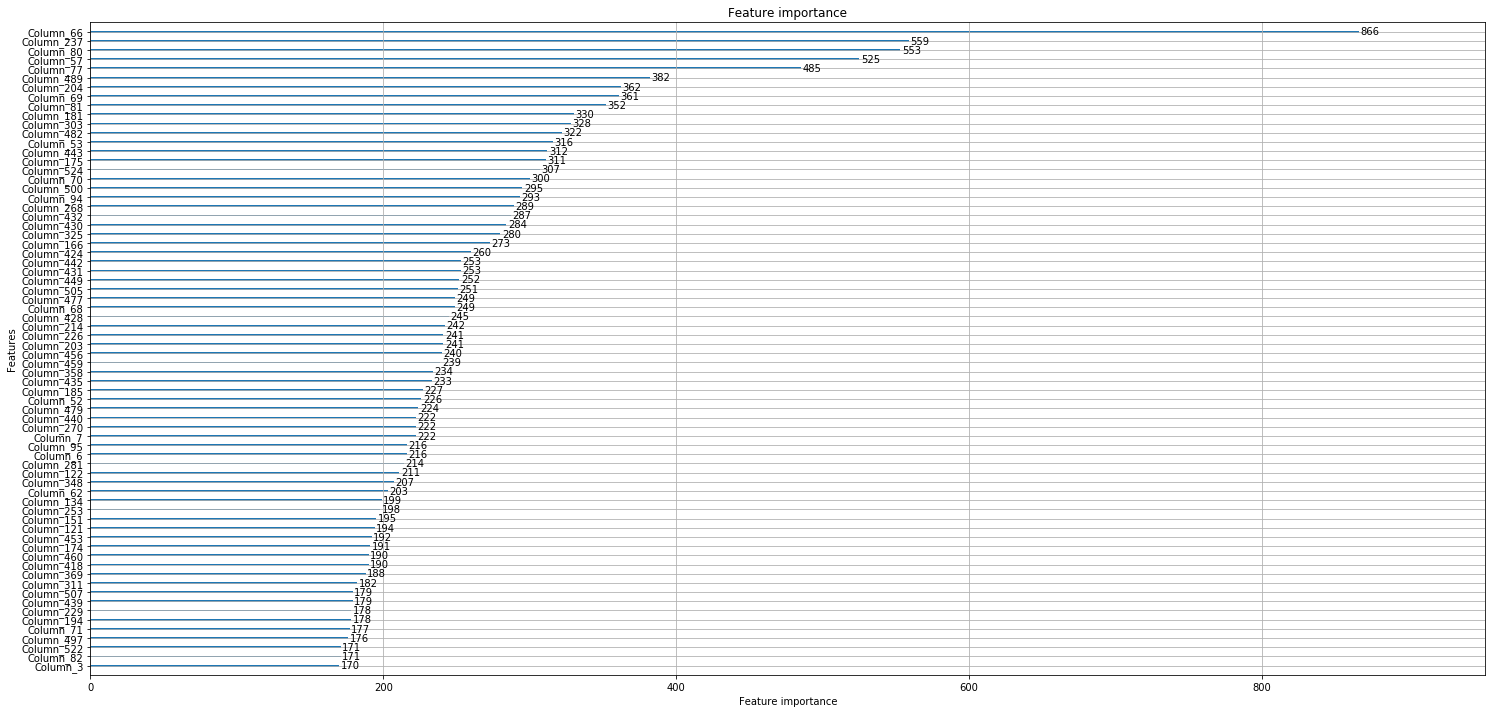

In [12]:
lightgbm.plot_importance(lgbm["classifier"],figsize=(25,12),max_num_features=70)

In [13]:
features.iloc[:,66]

59497  99      0.0
       100     1.0
       101     1.0
       102     1.0
       103     1.0
              ... 
59519  2107    1.0
       2108    1.0
       2109    1.0
       2110    1.0
       2111    1.0
Name: temperature__large_standard_deviation__r_0.15000000000000002, Length: 486322, dtype: float64

In [14]:
df = features.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
lgbm_df = lightgbm.Dataset(df)

In [15]:
lgbm_df

In [16]:
len(lgbm["classifier"].feature_importances_)
lgbm["classifier"].feature_importances_

array([ 76, 162, 157, 170,  86,  35, 216, 222,  96,  80,  50,  40, 102,
        89, 102,  47,  36,  33,  90,  34,  38,  49,  53,  86,  84,  80,
        31,  30,  73,  39,  48,  27,  68, 107,  34,  37,  33,  94,  35,
        41,  66,  81,  60,  66,  75,  72,  51, 100,  54,  40,  44,  81,
       226, 316,  44, 112,  77, 525,  93,  29,  83,  50, 203,  64,  62,
        36, 866,  92, 249, 361, 300, 177, 117,  61, 164,  78, 147, 485,
        53,  46, 553, 352, 171,  81,  56,  59,  59,  83,  86,  70,  45,
        63, 133,  60, 293, 216,  56, 110,  75,  50,  61,  49, 149,  76,
        67,  75, 132, 112,  59,  48,  58,  54,  54,  87, 168,  78, 144,
        51,  73,  51,  73, 194, 211,  82, 122,  85,  88, 153,  51,  77,
        64,  60,  77,  78, 199,  64,  48, 159,  56,  56, 110,  92,  75,
        81,  87, 161,  85,  89, 112, 117,  63, 195, 119,  70, 100, 124,
        94,  51,  53,  57,   0,  69, 106,  80,  61,  41, 273, 163,  67,
        67, 129,   3,  55, 116, 191, 311,  56,  26,  14,  16,  6

In [17]:
(x_array)

array([[1.        , 0.        , 0.        , ..., 1.18173997, 1.29826564,
        1.41596863],
       [1.        , 0.        , 0.        , ..., 1.17927748, 1.29542423,
        1.41271135],
       [1.        , 0.        , 0.        , ..., 1.17631638, 1.29205806,
        1.40890037],
       ...,
       [0.        , 1.        , 1.        , ..., 0.68161027, 0.8534822 ,
        1.02557423],
       [0.        , 1.        , 0.        , ..., 0.71154504, 0.8830483 ,
        1.05471579],
       [0.        , 1.        , 0.        , ..., 0.76741058, 0.93880912,
        1.11032031]])

In [18]:
lgbm.named_steps["augmenter"].relevant_features[66]

34

In [19]:
features.iloc[:,lgbm.named_steps["augmenter"].relevant_features]

temperature__sum_values  \
59497 99                      548.0   
      100                     536.5   
      101                     529.8   
      102                     526.4   
      103                     524.9   
...                             ...   
59519 2107                    175.7   
      2108                    175.3   
      2109                    174.9   
      2110                    174.4   
      2111                    174.0   

            temperature__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20)  \
59497 99                                            12.701650                     
      100                                            9.996804                     
      101                                            8.489559                     
      102                                            7.812485                     
      103                                            7.558352                     
...                                                       ...                     
59519 2107                                           0.736974                     
      2108                                           0.748362                     
      2109                                           0.757823                     
      2110                                           0.764988                     
      2111                                           0.769539                     

            temperature__cwt_coefficients__coeff_1__w_5__widths_(2, 5, 10, 20)  \
59497 99                                            12.051964                    
      100                                            8.457092                    
      101                                            6.490991                    
      102                                            5.700956                    
      103                                            5.524463                    
...                                                       ...                    
59519 2107                                           0.790245                    
      2108                                           0.802066                    
      2109                                           0.816661                    
      2110                                           0.833342                    
      2111                                           0.850690                    

            temperature__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)  \
59497 99                                            14.494705                    
      100                                            9.855849                    
      101                                            6.981525                    
      102                                            5.707365                    
      103                                            5.403135                    
...                                                       ...                    
59519 2107                                           1.114579                    
      2108                                           1.114579                    
      2109                                           1.114579                    
      2110                                           1.114595                    
      2111                                           1.114720                    

            temperature__cwt_coefficients__coeff_0__w_20__widths_(2, 5, 10, 20)  \
59497 99                                            16.224234                     
      100                                           14.190229                     
      101                                           13.004141                     
      102                                           12.406437                     
      103                                           12.100160                     
...                                                       ...                 

In [20]:
features.iloc[:,117]

59497  99      12.701650
       100      9.996804
       101      8.489559
       102      7.812485
       103      7.558352
                 ...    
59519  2107     0.736974
       2108     0.748362
       2109     0.757823
       2110     0.764988
       2111     0.769539
Name: temperature__cwt_coefficients__coeff_1__w_10__widths_(2, 5, 10, 20), Length: 486322, dtype: float64

In [21]:
lgbm["classifier"].feature_name_

['Column_0',
 'Column_1',
 'Column_2',
 'Column_3',
 'Column_4',
 'Column_5',
 'Column_6',
 'Column_7',
 'Column_8',
 'Column_9',
 'Column_10',
 'Column_11',
 'Column_12',
 'Column_13',
 'Column_14',
 'Column_15',
 'Column_16',
 'Column_17',
 'Column_18',
 'Column_19',
 'Column_20',
 'Column_21',
 'Column_22',
 'Column_23',
 'Column_24',
 'Column_25',
 'Column_26',
 'Column_27',
 'Column_28',
 'Column_29',
 'Column_30',
 'Column_31',
 'Column_32',
 'Column_33',
 'Column_34',
 'Column_35',
 'Column_36',
 'Column_37',
 'Column_38',
 'Column_39',
 'Column_40',
 'Column_41',
 'Column_42',
 'Column_43',
 'Column_44',
 'Column_45',
 'Column_46',
 'Column_47',
 'Column_48',
 'Column_49',
 'Column_50',
 'Column_51',
 'Column_52',
 'Column_53',
 'Column_54',
 'Column_55',
 'Column_56',
 'Column_57',
 'Column_58',
 'Column_59',
 'Column_60',
 'Column_61',
 'Column_62',
 'Column_63',
 'Column_64',
 'Column_65',
 'Column_66',
 'Column_67',
 'Column_68',
 'Column_69',
 'Column_70',
 'Column_71',
 '

In [22]:
lgbm["classifier"].n_features_in_

528

In [23]:
relevant_feature_names = features.iloc[:,lgbm.named_steps["augmenter"].relevant_features].columns

In [24]:
relevant_feature_lgbm_importance = lgbm["classifier"].feature_importances_

In [25]:
dict_relevant_features = {"feature": relevant_feature_names,
                         "lgbm_importance":relevant_feature_lgbm_importance}

In [26]:
df_relevant_features = pd.DataFrame(dict_relevant_features)

In [27]:
df_relevant_features

feature  lgbm_importance
0                              temperature__sum_values               76
1    temperature__cwt_coefficients__coeff_1__w_10__...              162
2    temperature__cwt_coefficients__coeff_1__w_5__w...              157
3    temperature__cwt_coefficients__coeff_1__w_2__w...              170
4    temperature__cwt_coefficients__coeff_0__w_20__...               86
..                                                 ...              ...
523  temperature__symmetry_looking__r_0.15000000000...                4
524  temperature__fft_coefficient__attr_"real"__coe...              307
525                     temperature__number_peaks__n_3               43
526              temperature__symmetry_looking__r_0.45                0
527           temperature__ratio_beyond_r_sigma__r_1.5              167

[528 rows x 2 columns]

In [28]:
df_rel_sorted = df_relevant_features.sort_values(by = ["lgbm_importance"],ascending = False)

In [29]:
df_rel_sorted.head(10).feature

66                                  temperature__minimum
237    temperature__energy_ratio_by_chunks__num_segme...
80                          temperature__quantile__q_0.1
57                                  temperature__maximum
77                      temperature__benford_correlation
489          temperature__ar_coefficient__coeff_10__k_10
204         temperature__approximate_entropy__m_2__r_0.1
69                          temperature__quantile__q_0.9
81                          temperature__quantile__q_0.2
181             temperature__spkt_welch_density__coeff_8
Name: feature, dtype: object

In [30]:
df_rel_sorted

feature  lgbm_importance
66                                temperature__minimum              866
237  temperature__energy_ratio_by_chunks__num_segme...              559
80                        temperature__quantile__q_0.1              553
57                                temperature__maximum              525
77                    temperature__benford_correlation              485
..                                                 ...              ...
357             temperature__ratio_beyond_r_sigma__r_7                0
467       temperature__large_standard_deviation__r_0.8                0
495  temperature__symmetry_looking__r_0.30000000000...                0
481      temperature__large_standard_deviation__r_0.05                0
466      temperature__large_standard_deviation__r_0.65                0

[528 rows x 2 columns]

In [31]:
feature_names = features.iloc[:,lgbm.named_steps["augmenter"].features].columns
feature_pval = lgbm.named_steps["augmenter"].p_values
dict_feature_pval = {"feature":feature_names,
                    "p_value":feature_pval}
df_feature_pval = pd.DataFrame(dict_feature_pval)


In [32]:
df_feature_pval

feature  p_value
0                              temperature__sum_values      0.0
1    temperature__cwt_coefficients__coeff_1__w_10__...      0.0
2    temperature__cwt_coefficients__coeff_1__w_5__w...      0.0
3    temperature__cwt_coefficients__coeff_1__w_2__w...      0.0
4    temperature__cwt_coefficients__coeff_0__w_20__...      0.0
..                                                 ...      ...
536  temperature__agg_linear_trend__attr_"stderr"__...      NaN
537  temperature__agg_linear_trend__attr_"stderr"__...      NaN
538  temperature__agg_linear_trend__attr_"stderr"__...      NaN
539  temperature__agg_linear_trend__attr_"stderr"__...      NaN
540            temperature__ratio_beyond_r_sigma__r_10      NaN

[541 rows x 2 columns]

In [33]:
df_feature_pval[df_feature_pval.feature.isin(df_rel_sorted.feature)].p_value

0      0.000000e+00
1      0.000000e+00
2      0.000000e+00
3      0.000000e+00
4      0.000000e+00
           ...     
523    7.237928e-56
524    7.086524e-08
525    4.448361e-97
526    1.025708e-30
527    4.494864e-06
Name: p_value, Length: 528, dtype: float64

In [34]:
df_relevant_features["p_value"] = df_feature_pval[df_feature_pval.feature.isin(df_rel_sorted.feature)].p_value

In [35]:
df_relevant_features

feature  lgbm_importance  \
0                              temperature__sum_values               76   
1    temperature__cwt_coefficients__coeff_1__w_10__...              162   
2    temperature__cwt_coefficients__coeff_1__w_5__w...              157   
3    temperature__cwt_coefficients__coeff_1__w_2__w...              170   
4    temperature__cwt_coefficients__coeff_0__w_20__...               86   
..                                                 ...              ...   
523  temperature__symmetry_looking__r_0.15000000000...                4   
524  temperature__fft_coefficient__attr_"real"__coe...              307   
525                     temperature__number_peaks__n_3               43   
526              temperature__symmetry_looking__r_0.45                0   
527           temperature__ratio_beyond_r_sigma__r_1.5              167   

          p_value  
0    0.000000e+00  
1    0.000000e+00  
2    0.000000e+00  
3    0.000000e+00  
4    0.000000e+00  
..            ...  
523  7.237928e-56  
524  7.086524e-08  
525  4.448361e-97  
526  1.025708e-30  
527  4.494864e-06  

[528 rows x 3 columns]

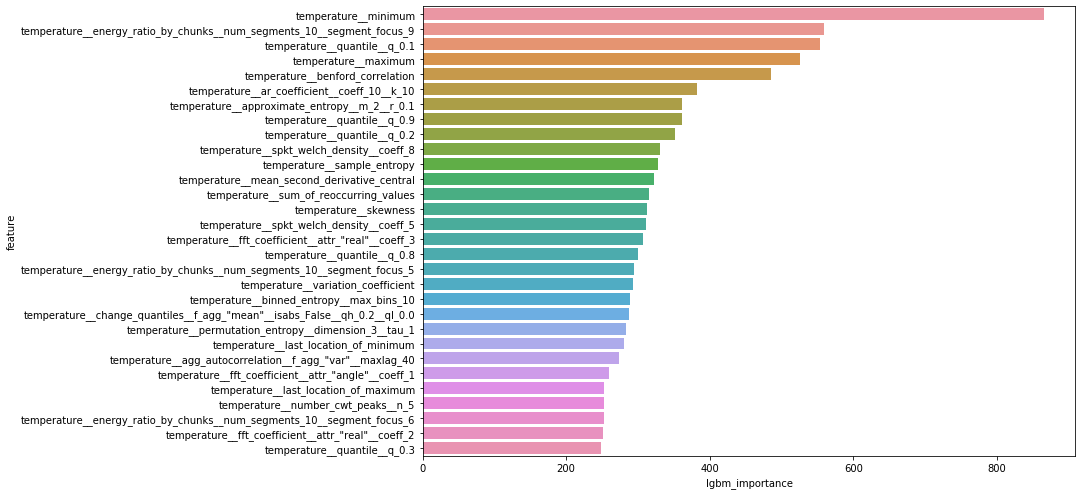

In [36]:
import seaborn as sns
from matplotlib import pyplot as plt
#sns.set_theme(style="whitegrid")
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
df_rel_sorted = df_relevant_features.sort_values(by = ["lgbm_importance"],ascending = False)
sns.barplot(x="lgbm_importance",y="feature",data = df_rel_sorted[:30])

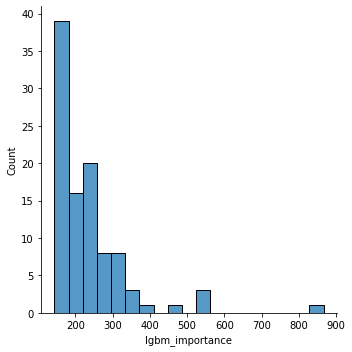

In [37]:
sns.displot(data = df_rel_sorted[:100],x="lgbm_importance")

In [38]:
#df_relevant_features.to_hdf(r'C:\Users\AliHa\Desktop\Masters Project\medangel\data\preprocessed\feature_importance.h5',key='df')

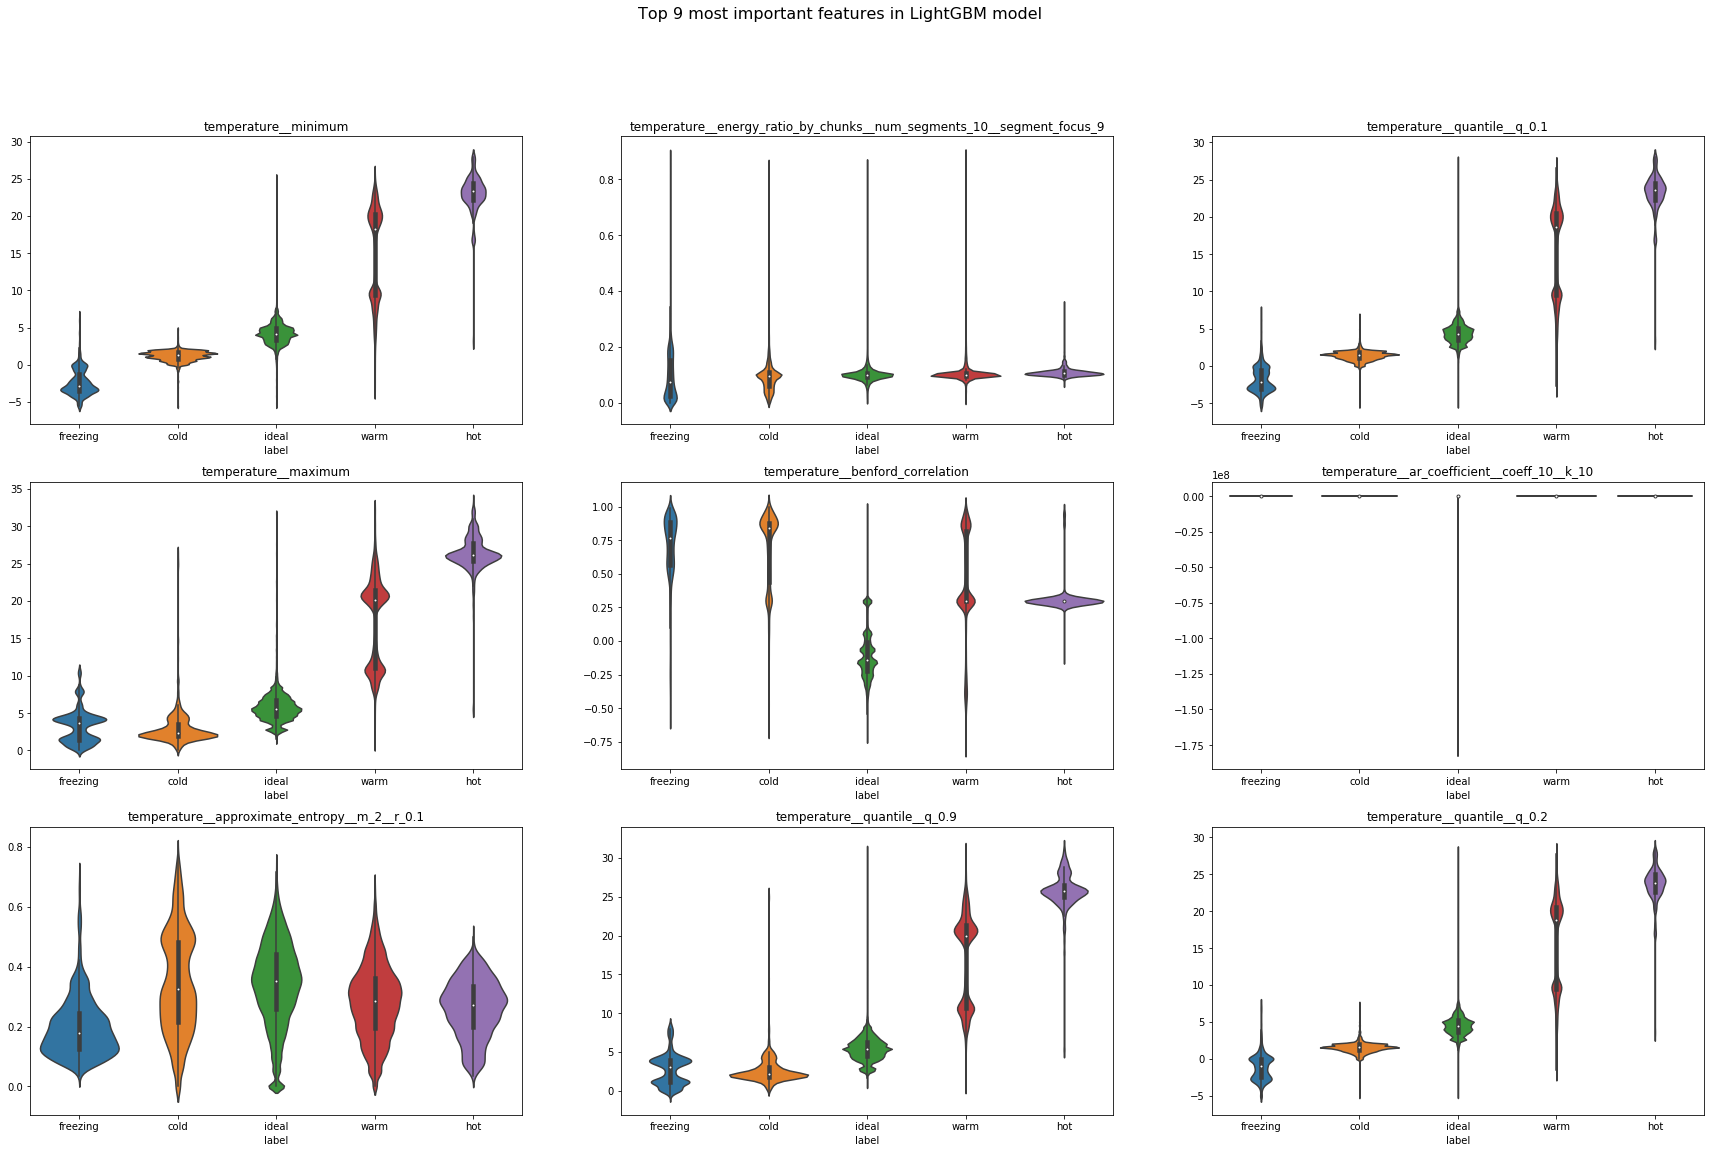

In [39]:
df_rel_sorted = df_rel_sorted.reset_index()
fig,axs = plt.subplots(3,3)
fig.set_size_inches(30,18)
fig.suptitle("Top 9 most important features in LightGBM model",fontsize=16)
log_transform = ["temperature__ar_coefficient__coeff_10__k_10","temperature__energy_ratio_by_chunks__num_segments_10__segment_focus_9"]
xy_matrix = features
xy_matrix["label"] = y_temp.label_shifted
imp = 0
for i in range(3):
    for j in range(3):
       # if df_rel_sorted.feature[imp] in log_transform:
            #xy_matrix[df_rel_sorted.feature[imp]] = xy_matrix[df_rel_sorted.feature[imp]].apply(lambda x: np.log(x))
        #    xy_matrix[df_rel_sorted.feature[imp]] = xy_matrix[df_rel_sorted.feature[imp]].apply(lambda x: 10**(x+1))
        sns.violinplot(x="label",y=df_rel_sorted.feature[imp], data = xy_matrix, ax=axs[i,j],order=["freezing","cold","ideal","warm","hot"])
        axs[i,j].set_ylabel('')
        axs[i,j].set_title(df_rel_sorted.feature[imp])
        imp +=1

In [40]:
xy_matrix.temperature__ar_coefficient__coeff_10__k_10

59497  99     -0.026891
       100    -0.026732
       101    -0.066020
       102    -0.082708
       103    -0.110362
                 ...   
59519  2107    0.083615
       2108    0.087697
       2109    0.092640
       2110    0.112965
       2111    0.095415
Name: temperature__ar_coefficient__coeff_10__k_10, Length: 486322, dtype: float64

In [41]:
df_rel_sorted.sort_values(by=['lgbm_importance'], ascending =[0]).head(50)

index                                            feature  lgbm_importance  \
0      66                               temperature__minimum              866   
1     237  temperature__energy_ratio_by_chunks__num_segme...              559   
2      80                       temperature__quantile__q_0.1              553   
3      57                               temperature__maximum              525   
4      77                   temperature__benford_correlation              485   
5     489        temperature__ar_coefficient__coeff_10__k_10              382   
6     204       temperature__approximate_entropy__m_2__r_0.1              362   
7      69                       temperature__quantile__q_0.9              361   
8      81                       temperature__quantile__q_0.2              352   
9     181           temperature__spkt_welch_density__coeff_8              330   
10    303                        temperature__sample_entropy              328   
11    482        temperature__mean_second_derivative_central              322   
12     53             temperature__sum_of_reoccurring_values              316   
13    443                              temperature__skewness              312   
14    175           temperature__spkt_welch_density__coeff_5              311   
15    524  temperature__fft_coefficient__attr_"real"__coe...              307   
16     70                       temperature__quantile__q_0.8              300   
17    500  temperature__energy_ratio_by_chunks__num_segme...              295   
18     94                 temperature__variation_coefficient              293   
19    268           temperature__binned_entropy__max_bins_10              289   
20    432  temperature__change_quantiles__f_agg_"mean"__i...              287   
21    430  temperature__permutation_entropy__dimension_3_...              284   
22    325              temperature__last_location_of_minimum              280   
23    166  temperature__agg_autocorrelation__f_agg_"var"_...              273   
24    424  temperature__fft_coefficient__attr_"angle"__co...              260   
25    431              temperature__last_location_of_maximum              253   
26    442                 temperature__number_cwt_peaks__n_5              253   
27    449  temperature__energy_ratio_by_chunks__num_segme...              252   
28    505  temperature__fft_coefficient__attr_"real"__coe...              251   
29     68                       temperature__quantile__q_0.3              249   
30    477             temperature__first_location_of_minimum              249   
31    428  temperature__energy_ratio_by_chunks__num_segme...              245   
32    214       temperature__approximate_entropy__m_2__r_0.3              242   
33    203  temperature__change_quantiles__f_agg_"mean"__i...              241   
34    226             temperature__first_location_of_maximum              241   
35    456  temperature__agg_linear_trend__attr_"slope"__c...              240   
36    459  temperature__agg_linear_trend__attr_"rvalue"__...              239   
37    358  temperature__time_reversal_asymmetry_statistic...              234   
38    435  temperature__fft_coefficient__attr_"angle"__co...              233   
39    185  temperature__change_quantiles__f_agg_"mean"__i...              227   
40     52        temperature__sum_of_reoccurring_data_points              226   
41    479  temperature__energy_ratio_by_chunks__num_segme...              224   
42    270  temperature__permutation_entropy__dimension_7_...              222   
43    440             temperature__longest_strike_above_mean              222   
44      7  temperature__agg_linear_trend__attr_"intercept...              222   
45      6  temperature__agg_linear_trend__attr_"intercept...              216   
46     95    temperature__fft_aggregated__aggtype_"centroid"              216   
47    281  temperature__agg_linear_trend__attr_"slope"__c...              214   
48    122  temperature__fft_coeffic

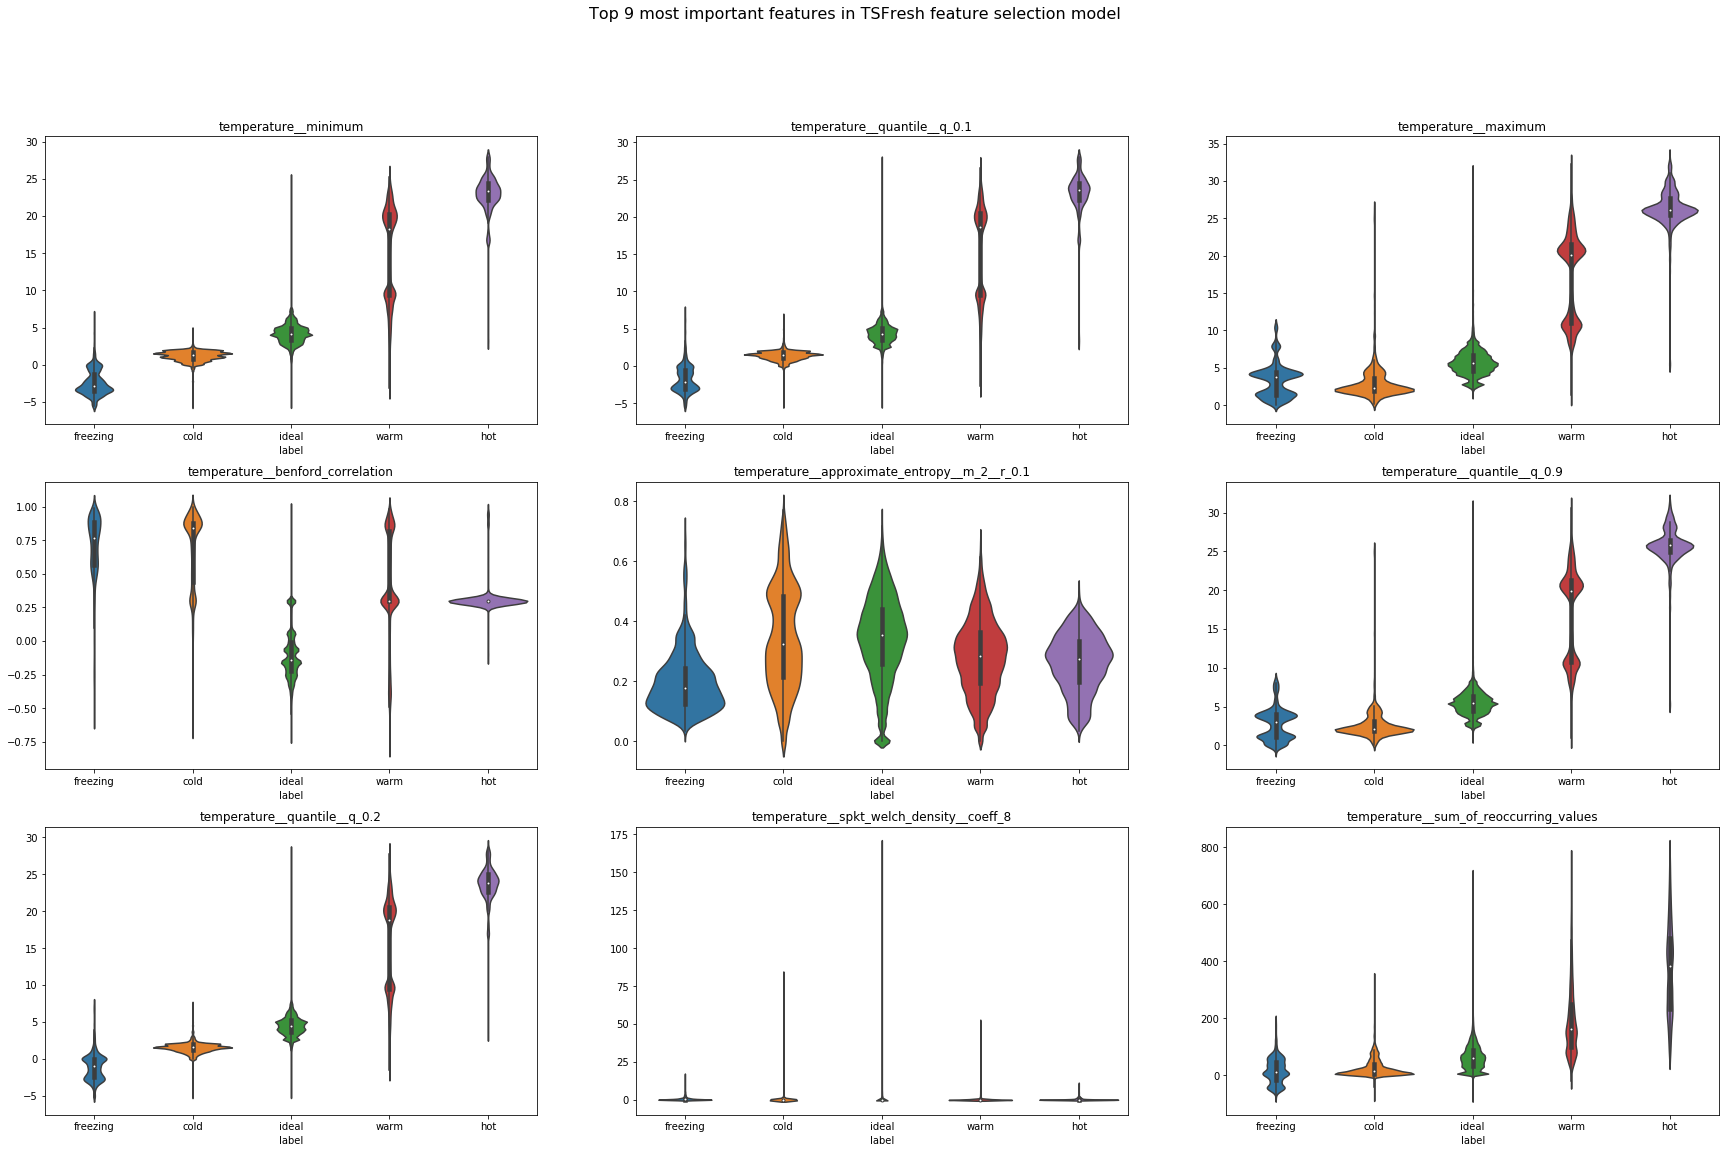

In [42]:
df_pval_sorted = df_rel_sorted.sort_values(by=["p_value",'lgbm_importance'], ascending =[1,0])
df_pval_sorted = df_pval_sorted.drop(columns = ["index"])
df_pval_sorted = df_pval_sorted.reset_index()
fig,axs = plt.subplots(3,3)
fig.set_size_inches(30,18)
fig.suptitle("Top 9 most important features in TSFresh feature selection model",fontsize=16)
xy_matrix = features
xy_matrix["label"] = y_temp.label_shifted
imp = 0
for i in range(3):
    for j in range(3):
        sns.violinplot(x="label",y=df_pval_sorted.feature[imp], data = xy_matrix, ax=axs[i,j],order=["freezing","cold","ideal","warm","hot"])
        axs[i,j].set_ylabel('')
        axs[i,j].set_title(df_pval_sorted.feature[imp])
        imp +=1

In [43]:
df_rel_sorted.feature[imp]

'temperature__spkt_welch_density__coeff_8'